# Predicting Optimal crop for Sowing

![Farmers in a field](kwara-agric.jpg)

## 1 Introduction

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers in Nigeria have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

The dataset `soil_measures.csv` contains the following:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  
### Data source

* <a href="https://1drv.ms/u/s!ArhE6TZzYOy0gaZhFH_B3wthGUSjyQ?e=NR2gjH" target="_blank">
    <img src= "https://img.shields.io/badge/OneDrive-white?style=for-the-badge&logo=Microsoft%20OneDrive&logoColor=0078D4" alt="ONEDRIVE">
 </a>


### 1.1 Summary

* Dataset mostly has numerical data
* Built a multi-class logistic regression model to predict optimal crops

## 2.1 Libraries & Configurations

## 2.1 Libraries

In [10]:
"""import relevant libraries"""
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display # for markdown function

# utility function to print markdown string
def printmd(string):
    display(Markdown(string))
#function to check for number of rows and colunms
def shape(df):
    print(f"There are {df.shape[0]:,} rows and {df.shape[1]} columns")


<a id='2.2'></a>
## 2.2 Configurations

In [95]:
# seed value
SEED = 42
#set seaborn theme
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', None)


## 3 Exploratory data Analysis

In [4]:
#loading the dataset
crops = pd.read_csv("soil_measures.csv")
crops.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [14]:
#checking for number of rows and colunms
shape(crops)

There are 2,200 rows and 5 columns


In [12]:
#checking information about the dataset
crops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2200 non-null   int64  
 1   P       2200 non-null   int64  
 2   K       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB


## 3.1 Checking for missing values

In [16]:
#checking for missing values
crops.isna().sum()


N       0
P       0
K       0
ph      0
crop    0
dtype: int64

## 3.2 Summary of feature colunms

In [60]:
#Taking a look our feature colunms
crops.describe(exclude=["object"]).T

,count,mean,std,min,25%,50%,75%,max
N,2200.0,50.551818,36.917334,0.000000,21.000000,37.000000,84.250000,140.000000
P,2200.0,53.362727,32.985883,5.000000,28.000000,51.000000,68.000000,145.000000
K,2200.0,48.149091,50.647931,5.000000,20.000000,32.000000,49.000000,205.000000
ph,2200.0,6.469480,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091


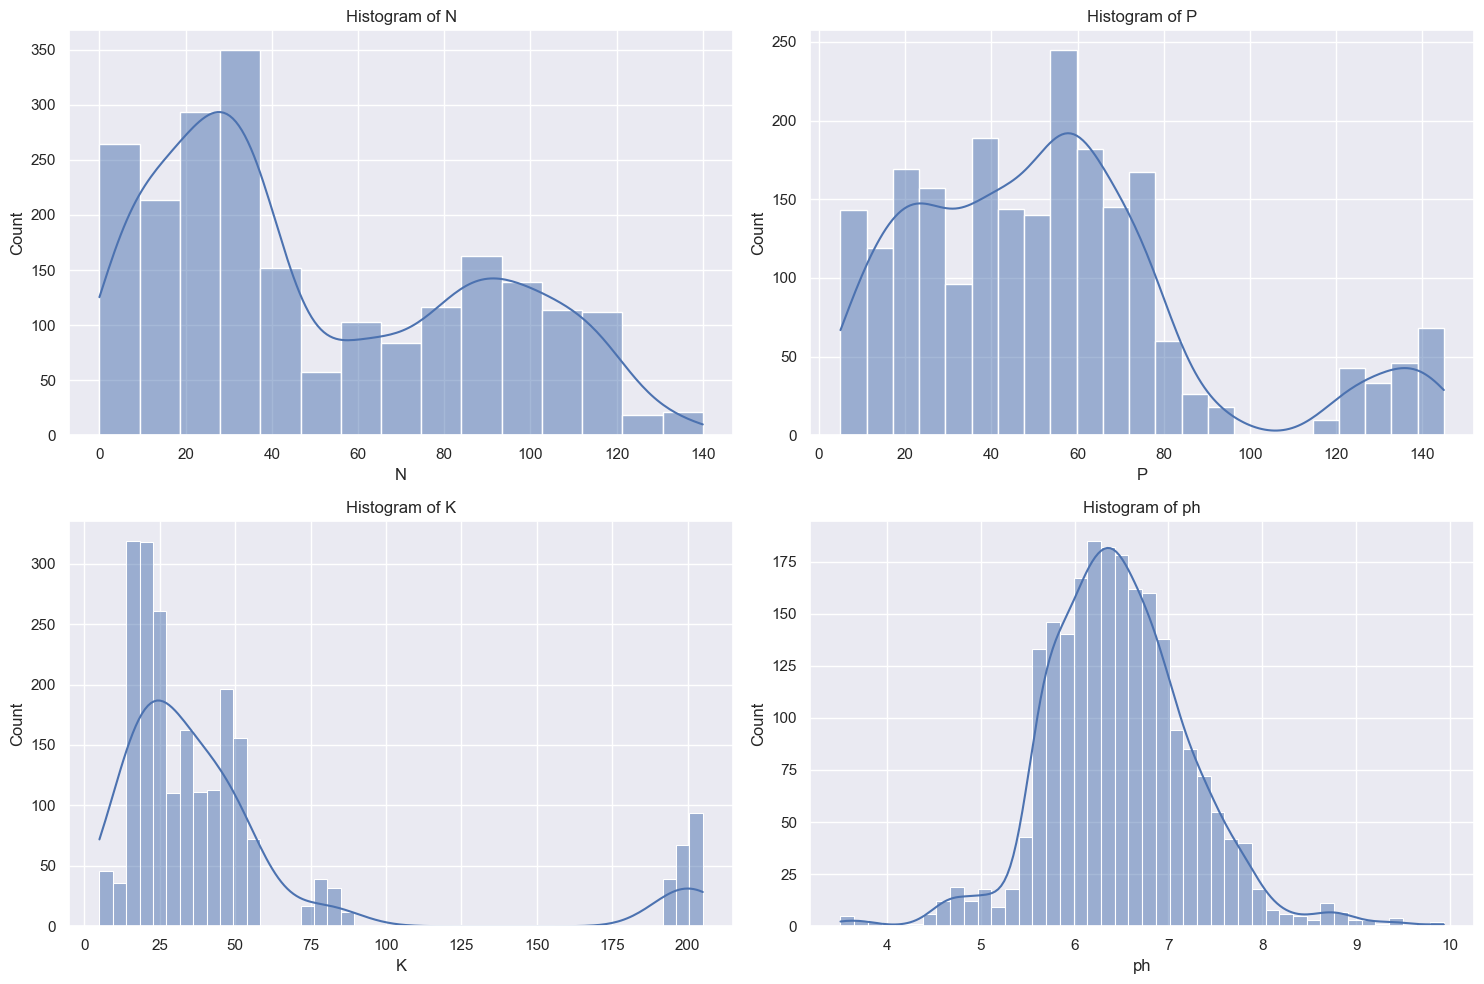

In [58]:
#Distribution of the feature colunms
feature = crops.drop("crop",axis=1)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Create a figure with 4 subplots

for i, col in enumerate(feature):
    sns.histplot(data=feature, x=col,kde=True, ax=axs[i//2, i%2])  # Create a histplot for each column
    axs[i//2, i%2].set_title(f'Histogram of {col}')  # Set the title for each subplot

plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()


## 3.3 Summary of Target column

In [61]:
#Taking a look the target colunm
crops.describe(include=["object"]).T

,count,unique,top,freq
crop,2200,22,rice,100


In [73]:
#showing the distrubution of crops in our dataset
crops_crop=crops.crop.value_counts().sort_values(ascending=False).reset_index()
print(crops_crop)
printmd("The crops in the data set are uniformly distributed")

           crop  count
0          rice    100
1         maize    100
2      chickpea    100
3   kidneybeans    100
4    pigeonpeas    100
5     mothbeans    100
6      mungbean    100
7     blackgram    100
8        lentil    100
9   pomegranate    100
10       banana    100
11        mango    100
12       grapes    100
13   watermelon    100
14    muskmelon    100
15        apple    100
16       orange    100
17       papaya    100
18      coconut    100
19       cotton    100
20         jute    100
21       coffee    100


The crops in the data set are uniformly distributed

## 4 Multi_class Logistic Regression Model

In [74]:
#Defining the feature and target colunms
X=crops.drop("crop",axis=1).values #featrue columns
y=crops["crop"] # Target column

In [76]:
#Spliting our dataset into Train and Test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=True)
#Normalizing our Datset with a standard scaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
#Expatiating the Logistic regression model
logreg=LogisticRegression(multi_class='multinomial', solver='lbfgs')
#Training our model on the training set
logreg.fit(X_train_scaled,y_train)

LogisticRegression(multi_class='multinomial')

In [90]:
#Evaluating the performance of our model
y_pred=logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred, average='weighted'))
print("Recall: ", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score: ", f1_score(y_test, y_pred, average='weighted'))
print("AUC: ", roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
print("Log Loss: ", log_loss(y_test, y_pred_proba))
printmd("Our model was able to accuratly predict the Optimal crop for sowing, 65% of the time")


Confusion Matrix:
 [[ 8  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0  6  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0 14  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [15  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0 12  0  0  0  0  0  0  0  0  1  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  9  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  3  0  0  0  0  0  0  0  7  1  2  0  0  0  0  4  0  0]
 [ 0  0  3  0  0  0  0  0  0  2  3  1  4  7  3  0  0  0  1  0  0  0]
 [ 0  0  2  0  

Our model was able to accuratly predict the Optimal crop for sowing, 65% of the time

In [98]:
#Taking a closer look at our confussion matrix to see how our model performed crop by crop
cm=confusion_matrix(y_test, y_pred)
labels=list(y.unique())
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
df_cm

,rice,maize,chickpea,kidneybeans,pigeonpeas,mothbeans,mungbean,blackgram,lentil,pomegranate,banana,mango,grapes,watermelon,muskmelon,apple,orange,papaya,coconut,cotton,jute,coffee
rice,8,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0
maize,0,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
chickpea,0,0,19,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
kidneybeans,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
pigeonpeas,0,0,0,0,9,0,0,0,0,0,0,0,6,0,0,0,0,0,0,3,0,0
mothbeans,0,0,0,0,0,14,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mungbean,0,0,0,0,0,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
blackgram,15,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0
lentil,0,0,0,0,0,0,1,0,12,0,0,0,0,0,0,0,0,1,0,0,11,0
pomegranate,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,9,0,0,0


In [101]:
#Taking alook at our model coefficients
coef= logreg.coef_
coef_colunms=crops.drop("crop",axis=1)
col=coef_colunms.columns
df_coef = pd.DataFrame(coef, index=labels, columns=col)
df_coef

,N,P,K,ph
rice,-1.456568,4.045374,4.477771,-1.261766
maize,3.636249,5.228554,1.635240,-1.036478
chickpea,-0.106683,4.476400,-3.716911,1.041619
kidneybeans,-1.337086,0.696082,5.374780,1.265521
pigeonpeas,-2.101012,-5.462678,0.140189,-0.563871
mothbeans,3.906858,-3.842300,-3.264565,0.745447
mungbean,6.482511,1.100848,-4.846393,1.040671
blackgram,-0.547862,3.128112,5.482256,-0.426427
lentil,2.127279,-0.071213,1.215454,0.557986
pomegranate,-2.571801,4.113636,-1.689026,-0.883853


{'N': 0.3150433405922865, 'P': 0.38626796555501347, 'K': 0.31663422793789947, 'ph': 0.11866031511399111}


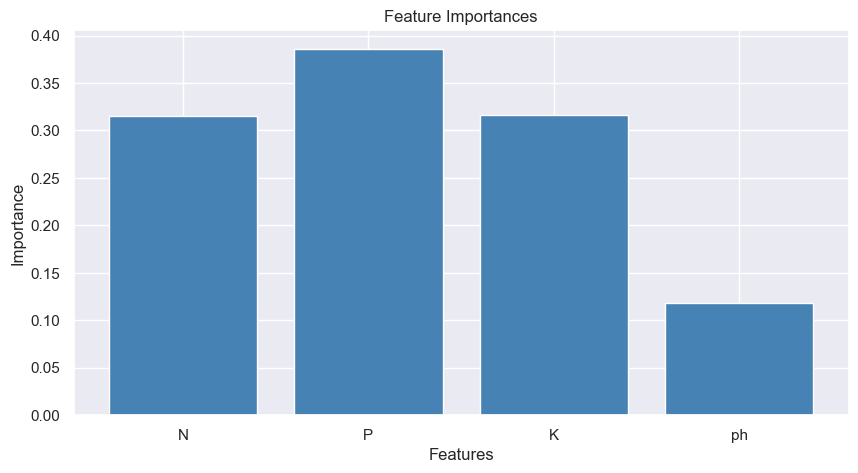

The most important feature is the Phosphorous content of the soil

In [107]:
#Checking our most important feature
result = permutation_importance(logreg, X_test_scaled, y_test,scoring='f1_weighted', n_repeats=10, random_state=42, n_jobs=2)

# Get importance
importances = result.importances_mean
# Print the feature importance
feature_importance = {feature: importance for feature, importance in zip(col, importances)}

# Now feature_importance is a dictionary where the key is the feature name and the value is the importance
print(feature_importance)
features = list(feature_importance.keys())
importances = list(feature_importance.values())
# Create the bar plot
plt.figure(figsize=(10, 5))  # Optional: You can set the figure size
plt.bar(features, importances, color='steelblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()
printmd("The most important feature is the Phosphorous content of the soil")

## 5.0 Conclusion

### The model has a performance of 65% in predicting optimal crop for sowing.The most important feature for the predictive analysis is the Phosphorous content of the soil.